# Exercise 1: Wiener Filter

In [2]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### (a) Optimal filter weights

In [3]:
R_x = np.array([[5, -1, -2],[-1, 5, -1],[-2, -1, 5]])
r_yx = np.array([1, 5.3, -3.9]).reshape((3,1))
R_x_inv = np.linalg.inv(R_x)

w_o = np.dot(R_x_inv,  r_yx)
print("Optimal weights are:\n", w_o)
print("")
print("inverse of R_x is:\n", R_x_inv)


Optimal weights are:
 [[ 0.2]
 [ 1. ]
 [-0.5]]

inverse of R_x is:
 [[0.26373626 0.07692308 0.12087912]
 [0.07692308 0.23076923 0.07692308]
 [0.12087912 0.07692308 0.26373626]]


# Exercise 2: Steepest Gradient Descent

### (b) Calculate eigenvalues of R_x

In [4]:
eigenvalues = np.linalg.eigvals(R_x)
print("eigenvalues of R_x are:\n", eigenvalues)
# alpha between 0 and 1/7

eigenvalues of R_x are:
 [2.26794919 7.         5.73205081]


### (c) Implementing the filter update rule of the GD algorithm 

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv('assignment1_data.csv', header=None)

# Assign column names assuming the first column is x and the second column is y
df.columns = ['x', 'y']

# Print the DataFrame to verify the data
print(df)

            x        y
0     0.00000  0.34438
1    -1.10410 -0.17451
2     0.31334 -0.66892
3    -0.88409 -0.14649
4    -1.96720 -0.82132
...       ...      ...
9995 -0.32324  1.42040
9996  1.03690 -0.61886
9997 -3.23190  0.46254
9998  3.57420 -3.25900
9999  1.42070  5.26790

[10000 rows x 2 columns]


In [6]:
weights = np.array([0,0,0]).reshape(3,1)
J, weights_history = [], []
alpha = 1e-3
R_x = np.array(([5, -1, -2],[-1, 5, -1],[-2, -1, 5]))
r_yx = np.array([1, 5.3, -3.9]).reshape((3,1))

for i in range(2,len(df)):

    #Predict
    x = np.array([df['x'][i-2],df['x'][i-1],df['x'][i]]).reshape(1,3)[0] #input
    y_hat = np.dot(x, weights)[0] #Prediction

    #Error
    y = df['y'][i] #ground truth y
    J.append(((y-y_hat)**2)) #calculate MSE loss

    #Update
    weights_history.append(weights) #Add current weights to history
    weights = weights + 2*alpha*(r_yx - np.dot(R_x, weights)) #Update weights according to known statistics

print("Final weights are:\n", weights)

Final weights are:
 [[ 0.2]
 [ 1. ]
 [-0.5]]


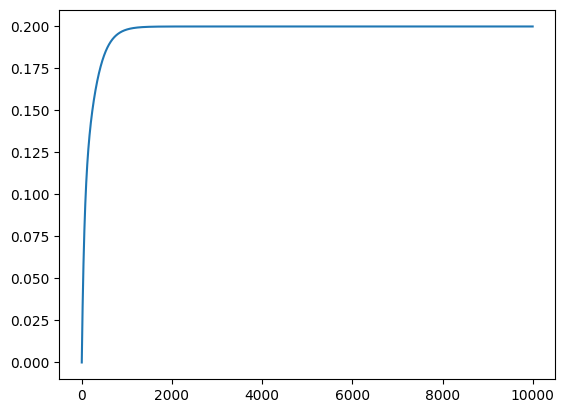

In [7]:
w0,w1,w2 = [],[],[]
for i in range(len(weights_history)):
    w0.append(weights_history[i][0])
    w1.append(weights_history[i][1])
    w2.append(weights_history[i][2])

plt.plot(w0)

# Exercise 3: Newton’s Method

# Exercise 4: LMS and NLMS

# Exercise 5: RLS